### This notebook is just to highlight the different chemistry data we have

In [42]:
# Build dataframe and plot per-chemistry totals

import pandas as pd
import matplotlib.pyplot as plt

# Input data
data = {
    "NCM":     {"CS2":0, "CX2":0, "Oxford":0, "PL":0, "Finland":3, "MIT":0, "Stanford":6, "ISU":256, "INR":2, "Tongji":0},
    "NCA":     {"CS2":0, "CX2":0, "Oxford":0, "PL":0, "Finland":3, "MIT":0, "Stanford":6, "ISU":0,   "INR":0, "Tongji":66},
    "LFP":     {"CS2":0, "CX2":0, "Oxford":0, "PL":0, "Finland":3, "MIT":124,"Stanford":0, "ISU":0,   "INR":0, "Tongji":0},
    "LCO":     {"CS2":10,"CX2":9,"Oxford":8,"PL":26,"Finland":0,"MIT":0,"Stanford":0,"ISU":0,"INR":0,"Tongji":0},
}

df = pd.DataFrame(data).fillna(0)

# Show the table
df.sample(5)

,NCM,NCA,LFP,LCO
ISU,256,0,0,0
Stanford,6,6,0,0
Oxford,0,0,0,8
INR,2,0,0,0
CS2,0,0,0,10


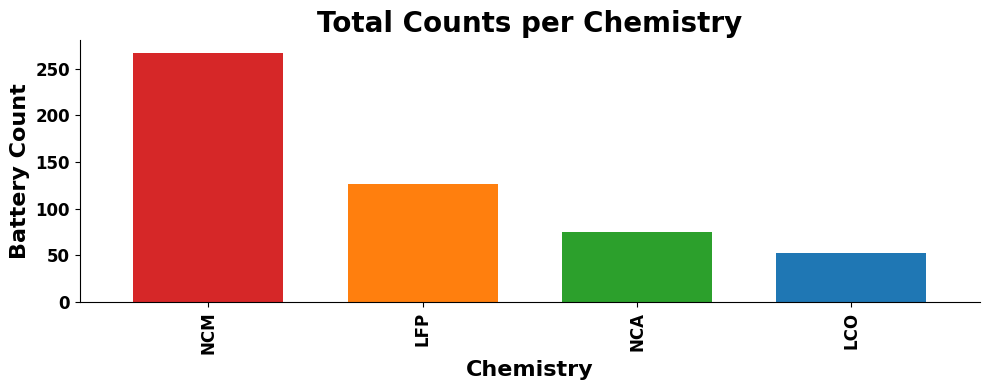

In [47]:
# Sum per chemistry and sort descending
chem_totals = df.sum(axis=0).sort_values(ascending=False)
chem_totals.to_frame(name="total")

# Plot the totals
plt.figure(figsize=(10,4))
# Remove white background
plt.gcf().patch.set_alpha(0)            # transparent figure
ax = plt.gca()
ax.set_facecolor('none')                # transparent axes
plt.rcParams['savefig.facecolor'] = 'none'

# Add some color
chem_palette = {
    "LCO": "#1f77b4",  # blue
    "LFP": "#ff7f0e",  # orange
    "NCA": "#2ca02c",  # green
    "NMC": "#d62728",  # red
}
bar_colors = [chem_palette.get(ch, "#d62728") for ch in chem_totals.index]

chem_totals.plot(kind="bar", color=bar_colors, width=0.7)
plt.title("Total Counts per Chemistry", fontsize=20, fontweight='bold')
plt.ylabel("Battery Count", fontsize=16, fontweight='bold')
plt.xlabel("Chemistry", fontsize=16, fontweight='bold')

# Update ax (reuse the same handle)
ax = plt.gca()
plt.setp(ax.get_xticklabels(), fontsize=12, fontweight='bold')
plt.setp(ax.get_yticklabels(), fontsize=12, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### Additional Figure for Raw Cycling Data

In [6]:
# First, let's just show the variety of features in the raw dataset, that we'll need to either 
# exclude or rename as a unified feature set. The purpose of sharing this here is to demonstrate
# The breadth of diversity across our different datasources that will need to be rectified 
# Note this may take 10-30s to run.

# Importing packages
import pandas as pd
import random
import os 
import json
from pathlib import Path
from scipy.io import loadmat

def pull_features(input_dir):
    """
    Randomly sample files from each provider folder and read only the
    first row/header to report feature names. Special-cased readers by source:
      - cx2 : read_excel, pick first sheet with "Channel" in the name (fallback first sheet)
      - cs2 : whitespace-delimited text or csv (pd.read_csv with delim_whitespace=True)
      - INR : read_excel, pick sheet with "Channel" in name if exists, else first sheet
      - MIT : read_csv (first row)
      - PL : read_csv from nested structure
      - Stanford : read_csv from nested structure
      - Oxford : read_csv from nested structure
      - TU_Finland : read_csv from nested structure
      - ISU : read_json (top-level keys) - processed last due to load time
    """
    
    input_path = Path(input_dir)
    if not input_path.exists():
        raise ValueError(f"{input_dir} does not exist.")

    # helper to safely read a single-row header for pandas readers
    def _read_csv_header(fp, **kwargs):
        try:
            df = pd.read_csv(fp, nrows=1, **kwargs)
            return df.columns.tolist()
        except Exception:
            return None

    def _read_excel_header(fp, sheet=None):
        try:
            if sheet is None:
                df = pd.read_excel(fp, nrows=1)
            else:
                df = pd.read_excel(fp, sheet_name=sheet, nrows=1)
            return df.columns.tolist()
        except Exception:
            return None

    def _read_mat_header(fp):
        """Extract column names from TU_Finland/Oxford MAT files."""
        try:
            mat_data = loadmat(fp)
            
            # Check for Oxford format (Cell1-Cell8 keys)
            oxford_cells = [k for k in mat_data.keys() if k.startswith('Cell') and not k.startswith('__')]
            if oxford_cells:
                # Oxford format: Cell1 -> cyc#### -> C1ch/C1dc -> t, v, q, T
                # Return the typical fields from Oxford data structure
                return ['t', 'v', 'q', 'T', 'C1ch', 'C1dc', 'OCVch', 'OCVdc']
            
            # Check for TU_Finland format (table key)
            table = mat_data.get("table")
            if table is not None:
                # TU_Finland MAT files have a 'table' structure with named fields
                entries = table[0] if hasattr(table, '__iter__') else [table]
                if len(entries) > 0:
                    entry = entries[0]
                    fields = []
                    if hasattr(entry, 'dtype') and hasattr(entry.dtype, 'names'):
                        fields = list(entry.dtype.names)
                    else:
                        # Fallback to common TU_Finland fields
                        fields = ['Time', 'Voltage', 'Current', 'Temperature']
                    return fields
            
            return None
        except Exception:
            return None

    def _find_files_recursive(folder, max_depth=3):
        """Recursively find files up to max_depth levels deep, excluding readme files."""
        files = []
        def recurse(path, depth):
            if depth > max_depth:
                return
            try:
                for item in path.iterdir():
                    if item.is_file() and item.suffix.lower() in ('.csv', '.txt', '.xls', '.xlsx', '.json', '.mat'):
                        # Exclude readme files
                        if 'readme' not in item.name.lower():
                            files.append(item)
                    elif item.is_dir():
                        recurse(item, depth + 1)
            except PermissionError:
                pass
        recurse(folder, 0)
        return files

    # Separate ISU to process last
    top_folders = sorted([p for p in input_path.iterdir() if p.is_dir()])
    isu_folder = None
    other_folders = []
    
    for folder in top_folders:
        if "isu" in folder.name.lower():
            isu_folder = folder
        else:
            other_folders.append(folder)

    # Dictionary to store results
    results = {}
    file_types = {}

    # Process all folders except ISU first
    for folder in other_folders:
        provider = folder.name.lower()
        features = None
        file_ext = None
        
        # Branch by provider label - use if/elif to avoid processing same folder twice
        if "cx2" in provider or "cx" in provider:
            # CX2: Excel files with Channel sheets - stop after first success
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".xls", ".xlsx") and not fp.name.startswith("~$"):
                    try:
                        xls = pd.ExcelFile(fp)
                        sheet = next((s for s in xls.sheet_names if "channel" in s.lower()), xls.sheet_names[0] if xls.sheet_names else None)
                        if sheet:
                            features = _read_excel_header(fp, sheet=sheet)
                            if features:
                                file_ext = fp.suffix.lower()
                                break
                    except Exception:
                        continue

        elif "cs2" in provider or "cs" in provider:
            # CS2: whitespace-delimited text files - stop after first success
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".txt", ".csv"):
                    features = _read_csv_header(fp, delim_whitespace=True)
                    if features is None:
                        features = _read_csv_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        elif "inr" in provider:
            # INR: Excel files, prefer sheet with "Channel" in name
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".xls", ".xlsx") and not fp.name.startswith("~$"):
                    try:
                        xls = pd.ExcelFile(fp)
                        sheet = next((s for s in xls.sheet_names if "channel" in s.lower()), xls.sheet_names[0] if xls.sheet_names else None)
                        if sheet:
                            features = _read_excel_header(fp, sheet=sheet)
                            if features:
                                file_ext = fp.suffix.lower()
                                break
                    except Exception:
                        continue

        elif "mit" in provider:
            # MIT: CSV format - stop after first success
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".csv", ".txt"):
                    features = _read_csv_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        elif "pl" in provider:
            # PL: CSV files in nested structure
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".csv", ".txt"):
                    features = _read_csv_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        elif "stanford" in provider:
            # Stanford: Excel files in nested structure
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() in (".xls", ".xlsx") and not fp.name.startswith("~$"):
                    try:
                        features = _read_excel_header(fp)
                        if features:
                            file_ext = fp.suffix.lower()
                            break
                    except Exception:
                        continue

        elif "oxford" in provider:
            # Oxford: MAT files
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() == ".mat":
                    features = _read_mat_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        elif "finland" in provider or "tu_finland" in provider:
            # TU_Finland: MAT files
            all_files = _find_files_recursive(folder)
            for fp in all_files:
                if fp.suffix.lower() == ".mat" and 'ocv' not in fp.name.lower():
                    features = _read_mat_header(fp)
                    if features:
                        file_ext = fp.suffix.lower()
                        break

        # Store results
        if features:
            results[folder.name] = features
            file_types[folder.name] = file_ext
        else:
            results[folder.name] = None
            file_types[folder.name] = None

    # Process ISU last due to JSON load time
    if isu_folder:
        features = None
        file_ext = None
        all_files = _find_files_recursive(isu_folder)
        json_files = [fp for fp in all_files if fp.suffix.lower() == ".json"]
        
        if json_files:
            # Only read one JSON file
            fp = json_files[0]
            try:
                with open(fp, "r", encoding="utf8") as fh:
                    # ISU files have double-encoded JSON - need to load twice
                    j = json.loads(json.load(fh))
                # Extract keys from the cycling data structure
                if isinstance(j, dict):
                    # Look for the main data keys (QV_charge, QV_discharge, etc.)
                    features = list(j.keys())
                    file_ext = fp.suffix.lower()
                elif isinstance(j, list) and len(j) > 0:
                    if isinstance(j[0], dict):
                        features = list(j[0].keys())
                        file_ext = fp.suffix.lower()
            except Exception as e:
                print(f"  Failed to read JSON {fp.name}: {e}")
        
        if features:
            results[isu_folder.name] = features
            file_types[isu_folder.name] = file_ext
        else:
            results[isu_folder.name] = None
            file_types[isu_folder.name] = None

    return results, file_types


def print_detailed_features(results):
    """Print detailed feature listings for each provider."""
    print("=" * 80)
    print("DETAILED FEATURE LISTINGS")
    print("=" * 80)
    for provider_name, feature_list in results.items():
        if feature_list:
            print(f"\nExample Features in {provider_name} Datafiles:")
            print(feature_list)
        else:
            print(f"\nNo readable feature header found for {provider_name}")


def print_feature_summary(results):
    """Print summary of feature counts for each provider."""
    print("=" * 80)
    print("SUMMARY")
    print("=" * 80)
    for provider_name, feature_list in results.items():
        if feature_list:
            print(f"{provider_name} files contain {len(feature_list)} features")
        else:
            print(f"{provider_name} files contain 0 features (no readable data)")


def print_file_types(file_types):
    """Print file extension types for each provider."""
    print("=" * 80)
    print("FILE TYPES BY PROVIDER")
    print("=" * 80)
    for provider_name, ext in file_types.items():
        if ext:
            print(f"{provider_name}: {ext}")
        else:
            print(f"{provider_name}: No file type detected")


# Load feature data from raw data files
feature_results, file_type_results = pull_features("../assets/raw_data")

C:\Users\MJone\AppData\Local\Temp\ipykernel_24036\924594357.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, nrows=1, **kwargs)


Reading: CX2_16_10_14_11.xlsx
Reading sheet: Channel_1-006
Columns: ['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index', 'Cycle_Index', 'Current(A)', 'Voltage(V)', 'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data', 'AC_Impedance(Ohm)', 'ACI_Phase_Angle(Deg)']
Shape: (21540, 17)


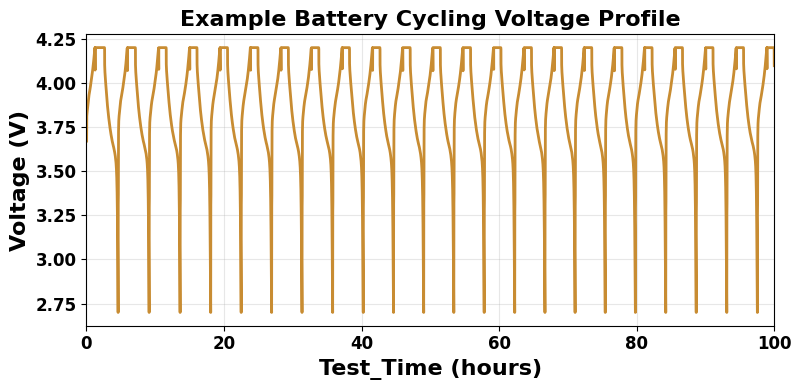

In [8]:
# Let's visualize a voltage vs. time trace from a CX2 file to see the raw cycling data
import matplotlib.pyplot as plt

report_plot = True

# Find a CX2 file
cx2_path = Path("../assets/raw_data/CX2")
cx2_files = [f for f in cx2_path.rglob("*.xls*") if not f.name.startswith("~$")]

if cx2_files:
    # Read the first CX2 file
    sample_file = cx2_files[0]
    print(f"Reading: {sample_file.name}")
    
    # CX2 files are Excel files with Channel sheets
    xls = pd.ExcelFile(sample_file)
    sheet_name = next((s for s in xls.sheet_names if "channel" in s.lower()), xls.sheet_names[0])
    print(f"Reading sheet: {sheet_name}")
    
    df_cx2 = pd.read_excel(sample_file, sheet_name=sheet_name)
    
    print(f"Columns: {df_cx2.columns.tolist()}")
    print(f"Shape: {df_cx2.shape}")
    
    # Plot Voltage(V) vs Test_Time(s)
    if 'Test_Time(s)' in df_cx2.columns and 'Voltage(V)' in df_cx2.columns:
        fig, ax = plt.subplots(figsize=(8, 4))
        # Remove white background
        fig.patch.set_alpha(0)          # transparent figure
        ax.set_facecolor('none')        # transparent axes
        plt.rcParams['savefig.facecolor'] = 'none'

        # Convert time to hours for better readability
        time_hours = df_cx2['Test_Time(s)'].values / 3600

        ax.plot(time_hours, df_cx2['Voltage(V)'].values, linewidth=2, color="#C88C32")
        ax.set_xlabel('Test_Time (hours)', fontsize=16, fontweight = 'bold')
        ax.set_ylabel('Voltage (V)', fontsize=16, fontweight = 'bold')
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlim(0,100)
        
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

        if report_plot == True: 
            ax.set_title(f"Example Battery Cycling Voltage Profile", fontsize=16, fontweight='bold')            
        else: 
            ax.set_title(f"Voltage vs. Time for {sample_file.name}", fontsize=20, fontweight='bold')

        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Could not find 'Test_Time(s)' or 'Voltage(V)' columns")
        print(f"Available columns: {df_cx2.columns.tolist()}")
else:
    print("No CX2 files found")

LFP Discharge: Plotted 100 points from MIT_20180412_cell_39_processed
NMC Discharge: Plotted 100 points from G20C2
LCO Discharge: Plotted 100 points from Oxford_Cell5
NCA Discharge: Plotted 100 points from nca_k6_278k


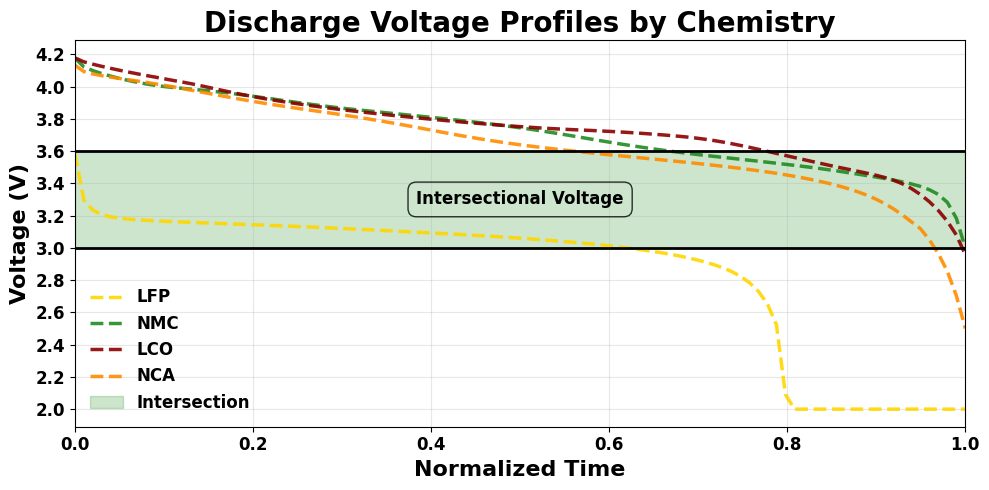

In [26]:
import numpy as np

# Plot charge and discharge curves for each chemistry overlaid
def plot_overlaid_chemistry_curves(intersect_min=3.0, intersect_max=3.6):
    """Plot one random discharge curve for each chemistry."""
    
    # Set paths
    processed_root = Path("../assets/processed").resolve()
    
    chemistries = ['LFP', 'NMC', 'LCO', 'NCA']
    colors = {'LFP': '#FFD700', 'NMC': '#228B22', 'LCO': '#8B0000', 'NCA': "#FF8C00FF"}
    
    fig, ax = plt.subplots(figsize=(10, 5))
    # Remove white background (transparent figure and axes)
    fig.patch.set_alpha(0)
    ax.set_facecolor('none')
    plt.rcParams['savefig.facecolor'] = 'none'
    
    random.seed(6)
    
    for chem in chemistries:
        chem_path = processed_root / chem
        
        if not chem_path.exists():
            print(f"Chemistry folder not found: {chem}")
            continue
        
        # Get all cell directories
        cell_dirs = [d for d in chem_path.iterdir() if d.is_dir()]
        
        if not cell_dirs:
            print(f"No cells found for {chem}")
            continue
        
        # Randomly sample one cell
        sample_cell = random.choice(cell_dirs)
        
        # Process discharge file
        discharge_files = [f for f in sample_cell.glob("*.csv") 
                          if "discharge" in f.name.lower() 
                          and "error" not in f.name.lower()]
        
        if discharge_files:
            try:
                df_discharge = pd.read_csv(discharge_files[0])
                
                # Filter to first cycle only if there are at least 2 unique cycles
                if 'cycle_index' in df_discharge.columns:
                    unique_cycles = df_discharge['cycle_index'].unique()
                    if len(unique_cycles) >= 2:
                        first_cycle = unique_cycles[0]
                        df_discharge = df_discharge[df_discharge['cycle_index'] == first_cycle]
                
                if 'voltage_v' in df_discharge.columns:
                    voltage = pd.to_numeric(df_discharge['voltage_v'], errors='coerce').dropna()
                    
                    if len(voltage) > 1:
                        if 'normalized_time' in df_discharge.columns:
                            time = pd.to_numeric(df_discharge['normalized_time'], errors='coerce')[:len(voltage)]
                        else:
                            time = np.arange(len(voltage))
                        
                        ax.plot(time, voltage.values, 
                                color=colors.get(chem, '#1f77b4'),
                                linestyle='--',
                                linewidth=2.5, alpha=0.9, label=chem)
                        
                        print(f"{chem} Discharge: Plotted {len(voltage)} points from {sample_cell.name}")
            except Exception as e:
                print(f"Error reading discharge file for {chem}: {e}")
    
    # Configure plot
    ax.set_xlabel("Normalized Time", fontsize=16, fontweight='bold')
    ax.set_ylabel("Voltage (V)", fontsize=16, fontweight='bold')
    ax.set_title("Discharge Voltage Profiles by Chemistry", fontsize=20, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_yticks(np.arange(2, 4.4, 0.2))
    ax.tick_params(axis='both', which='major', labelsize=12)
    

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    # Add horizontal lines at 3.0V and 3.6V
    ax.axhline(y=intersect_min, color='black', linewidth=2, linestyle='-', zorder=5)
    ax.axhline(y=intersect_max, color='black', linewidth=2, linestyle='-', zorder=5)
    
    # Add green shaded overlay for intersectional voltage window
    ax.fill_between(ax.get_xlim(), intersect_min, intersect_max, color='green', alpha=0.2, zorder=1, label='Intersection') 
    
    # Add text label in the middle of the intersectional voltage window
    xlim = ax.get_xlim()
    x_center = (xlim[0] + xlim[1]) / 2
    ax.text(
        x_center, (intersect_min + intersect_max)/2, 'Intersectional Voltage',
        fontsize=12, color='black', ha='center', va='center', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='none', edgecolor='black', alpha=0.8)  # transparent box
    )
    
    # Transparent legend box
    leg = ax.legend(fontsize=12, loc='best', framealpha=0)
    if leg:
        leg.get_frame().set_facecolor('none')
        leg.get_frame().set_edgecolor('none')
        for text in leg.get_texts():
            text.set_fontweight('bold')

    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot overlaid curves
plot_overlaid_chemistry_curves()


### Log-Reg Figures

In [1]:
#Import packages
import os 
import numpy as np 
import pandas as pd 
from scipy.stats import uniform, randint

#ML packages
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV


#Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns


#This may take up to a minute

In [2]:

def summarize_features(input_df, chemistry, chemistry_filepath, desired_features, clip=True):
    """This function takes the input_features and finds the mean, min, max and standard deviation for each of them,
    returning a dataframe of the aggregated features for each unique battery, along with its chemistry. 
    Inputs: input_df (pandas dataframe), chemistry (str), chemistry_filepath (str), desired_features (list), clip (bool)
    Outputs: agg_data (pandas dataframe)"""

    tdf = input_df[desired_features].copy()
    
    # Apply voltage clipping if enabled
    if clip and 'voltage_v' in tdf.columns:
        tdf = tdf[(tdf['voltage_v'] >= 3.0) & (tdf['voltage_v'] <= 3.6)] #3.0 & 3.6 are the intersectional voltage cutoffs between the different chemistries
    
    # If no data remains after clipping, return None
    if len(tdf) == 0:
        return None

    agg_data = {}
    for col in tdf.columns:
        agg_data[f"{col}_mean"] = tdf[col].mean()
        agg_data[f"{col}_std"] = tdf[col].std()
        agg_data[f"{col}_min"] = tdf[col].min()
        agg_data[f"{col}_max"] = tdf[col].max()
    
    # Add metadata
    agg_data["chemistry"] = chemistry
    agg_data["file"] = chemistry_filepath
    return agg_data


def agg_chem_features(input_dir, clip=True): 
    """This function walks through an input directory, finds each chemistry folder and the battery id 
    folders embedded in each of them. For each battery ID, it reads the file to a dataframe and 
    aggregates the desired features using summarize features.  
    Inputs: input_dir (str), clip (bool) - if True, filters voltage between 3.0 and 3.6V
    Outputs: result_df (pandas dataframe)"""

    chemistries = os.listdir(input_dir)
    desired_features = ["cycle_index","normalized_time","voltage_v", "c_rate","temperature_k"]
    all_data = []
    for chemistry in chemistries:
        chemistry_path = os.path.join(input_dir, chemistry)
        for chemistry_folder in os.listdir(chemistry_path):
            chemistry_filepath = os.path.join(chemistry_path, chemistry_folder)
            chemistry_filepath_dir = os.listdir(chemistry_filepath)
            desired_files = [temp_file for temp_file in chemistry_filepath_dir if "error_log" not in temp_file]
            
            charge_filepath = None
            discharge_filepath = None

            for file in desired_files: 
                if "discharge" in file:
                    discharge_filepath = os.path.join(chemistry_filepath, file)
                elif "charge" in file: 
                    charge_filepath = os.path.join(chemistry_filepath, file)
                    
            # Only proceed if both files were found
            if not (charge_filepath and discharge_filepath):
                continue
                
            # Read the file for charge and discharge 
            charge_df = pd.read_csv(charge_filepath)
            discharge_df = pd.read_csv(discharge_filepath)
            if len(charge_df) > 0 and len(discharge_df)>0: 
                if charge_df.c_rate.iloc[0] == "variable" or discharge_df.c_rate.iloc[0] == "variable": 
                    continue 
                else: 
                    charge_data = summarize_features(charge_df, chemistry, charge_filepath, desired_features, clip=clip)
                    discharge_data = summarize_features(discharge_df, chemistry, discharge_filepath, desired_features, clip=clip)
                    
                    # Skip if either charge or discharge had no data after clipping
                    if charge_data is None or discharge_data is None:
                        continue

                    # Convert dicts to DataFrames for concat
                    charge_data = pd.DataFrame([charge_data])
                    discharge_data = pd.DataFrame([discharge_data])

                    # Add column naming to distinguish between charge and discharge
                    charge_data.columns = ['charge_' + col if col not in ['chemistry', 'file'] else col for col in charge_data.columns]
                    discharge_data.columns = ['discharge_' + col if col not in ['chemistry', 'file'] else col for col in discharge_data.columns]

                    combined_df = pd.concat([charge_data, discharge_data], axis=1)  # ✅ axis=1 to combine horizontally
                    all_data.append(combined_df)
    
    # Combine all per-file aggregates
    result_df = pd.concat(all_data, ignore_index=True)  # ✅ concat instead of DataFrame(list_of_dfs)
    return result_df


def scrub_values(input_df): 
    """This function takes the input dataframe and removes any features from the dataframe if they are found 
     in the pre-specified strip_cols list, ultimately returning the subset feature dataframe.  
    Inputs: input_df (pandas dataframe)
    Outputs: strip_df (pandas dataframe)"""

    #Now let's remove unneeded features: 
    strip_cols = ['charge_cycle_index_min', 'charge_cycle_index_max', 'charge_cycle_index_mean', 'charge_cycle_index_std',
                'charge_normalized_time_min', 'charge_normalized_time_max', 'discharge_c_rate_min', 'discharge_c_rate_max',
                'discharge_c_rate_std', 'charge_c_rate_min', 'charge_c_rate_max', 'charge_c_rate_std', 
                'discharge_temperature_k_max', 'discharge_temperature_k_min', 'discharge_temperature_k_std',
                'charge_temperature_k_max', 'charge_temperature_k_min', 'charge_temperature_k_std', 
                'discharge_temperature_k_mean', 'file', 'discharge_cycle_index_mean', 'discharge_cycle_index_max',
                'discharge_cycle_index_min', 'discharge_cycle_index_std',
                'discharge_normalized_time_max', 'discharge_normalized_time_min', 'discharge_normalized_time_std',
                'charge_normalized_time_std', 'charge_normalized_time_mean', 'discharge_normalized_time_mean']

    strip_df = input_df.drop(columns=strip_cols, errors='ignore')
    strip_df = strip_df.iloc[:, :-1]
    strip_df.describe()
    return strip_df


input_dir = r'..\assets\processed'
print('Generating initial training data')
result_df = agg_chem_features(input_dir, clip=True)  # Set clip=True to filter voltage between 3.0-3.6V
print('Removing unwanted features')
strip_df = scrub_values(result_df).dropna()

print('Here is a quick overview:')
strip_df.sample(3)

#Note this may take up to 1 minute

Generating initial training data
Removing unwanted features
Here is a quick overview:


,charge_voltage_v_mean,charge_voltage_v_std,charge_voltage_v_min,charge_voltage_v_max,charge_c_rate_mean,charge_temperature_k_mean,chemistry,discharge_voltage_v_mean,discharge_voltage_v_std,discharge_voltage_v_min,discharge_voltage_v_max,discharge_c_rate_mean
304,3.517476,0.084009,3.406400,3.600000,1.00,298.00,LFP,3.128454,0.082939,3.000091,3.586300,1.00
346,3.550183,0.038796,3.472203,3.599284,0.05,298.15,NCA,3.432064,0.133055,3.058612,3.596913,0.05
152,3.560000,0.028108,3.529465,3.584794,0.05,278.15,NMC,3.398391,0.167309,3.020327,3.598360,0.05


d:\Capstone\Battery_Classifier\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Capstone\Battery_Classifier\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


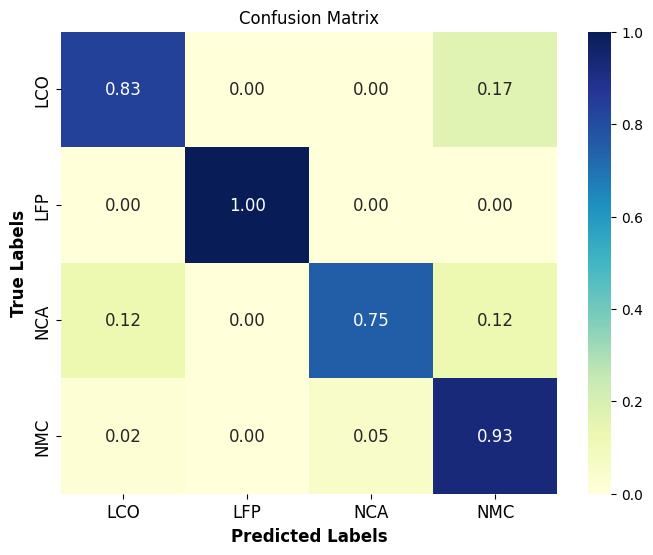

Classification Report:
              precision    recall  f1-score   support

         LCO       0.71      0.83      0.77         6
         LFP       1.00      1.00      1.00        48
         NCA       0.67      0.75      0.71         8
         NMC       0.96      0.93      0.95        57

    accuracy                           0.94       119
   macro avg       0.84      0.88      0.86       119
weighted avg       0.95      0.94      0.94       119



In [3]:
for_report = True


# Split between outcome and input variables
training_column = "chemistry"
y = strip_df[[training_column]]
X = strip_df.drop(columns=[training_column]) 

# Separate between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

#Prepare the encoder 
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Apply scaling to improve convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Load the model with increased iterations
model = LogisticRegression(solver='lbfgs', max_iter=2000)
model.fit(X_train_scaled, y_train_encoded)


predictions = model.predict(X_test_scaled)
probabilities = model.predict_proba(X_test_scaled)
# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, predictions, normalize='true')

# Optional: get the class labels (in the same order used by LabelEncoder)
labels = encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.title("Confusion Matrix")

plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
plt.ylabel("True Labels", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Print classification report too
print("Classification Report:")
print(classification_report(y_test_encoded, predictions, target_names=labels))


Best parameters found: {'C': np.float64(69.58780103230364), 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.9556213017751479

Classification Report:
              precision    recall  f1-score   support

         LCO       1.00      0.93      0.96        14
         LFP       1.00      1.00      1.00       159
         NCA       0.94      0.75      0.83        20
         NMC       0.96      0.99      0.98       145

    accuracy                           0.98       338
   macro avg       0.97      0.92      0.94       338
weighted avg       0.98      0.98      0.98       338



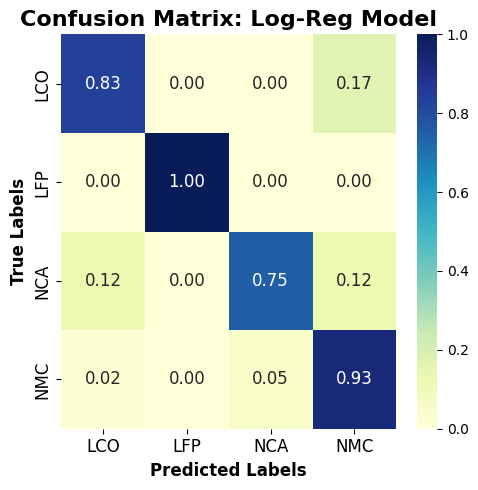

In [48]:
from scipy.stats import loguniform  # add this import

# Split the dataframe into our output and input features
y = strip_df[training_column]
X = strip_df.drop(columns=[training_column])

# Transform the output data for multi-class classification
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Apply scaling to the input feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Setup the base logistic regression model and the sweep conditions for the hyper parameter(s)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

param_dist = {
    'C': loguniform(1e-4, 1e2),
    'solver': ['lbfgs', 'saga']
}

# Load leave one out 
loo = LeaveOneOut()

# Setup the random search applying LeaveOneOut cross-validation
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=20,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Execute the random search
random_search.fit(X_scaled, y_encoded)

# Callout best model and its parameters
best_model = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

# Generate predictions based on the LOO training
predictions = best_model.predict(X_scaled)

# Examine prediction performance
print("\nClassification Report:")
print(classification_report(y_encoded, predictions, target_names=labels))

# Show the confusion matrix
cm_normalized = confusion_matrix(y_encoded, predictions, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})

if for_report == True: 
    plt.title("Confusion Matrix: Log-Reg Model", fontsize=16, fontweight='bold')
else: 
    plt.title("Confusion Matrix: Log-Reg Model")

plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
plt.ylabel("True Labels", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


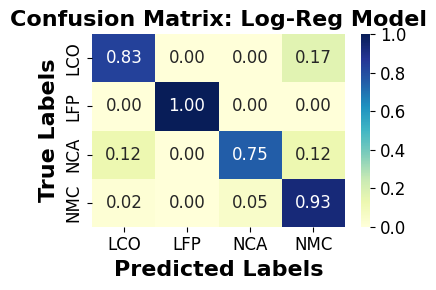

In [61]:
# Plot confusion matrix
plt.figure(figsize=(4, 3), facecolor='none')
ax = sns.heatmap(
    cm, annot=True, fmt='.2f', cmap='YlGnBu',
    xticklabels=labels, yticklabels=labels,
    annot_kws={"size": 12}
)

ax.set_facecolor('none')

if for_report == True: 
    plt.title("Confusion Matrix: Log-Reg Model", fontsize=16, fontweight='bold')
else: 
    plt.title("Confusion Matrix: Log-Reg Model")

plt.xlabel("Predicted Labels", fontsize=16, fontweight='bold')
plt.ylabel("True Labels", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12,)
plt.yticks(fontsize=12)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


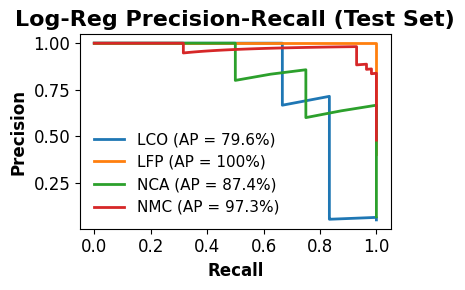


Average Precision Scores (Test Set):
  LCO: 79.6%
  LFP: 100%
  NCA: 87.4%
  NMC: 97.3%


In [66]:
# Precision Recall Curve:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Use the same test set and model as the confusion matrix cell
y_proba = model.predict_proba(X_test_scaled)
y_bin = label_binarize(y_test_encoded, classes=range(len(labels)))

# Plot Precision-Recall curves with transparent background
fig, ax = plt.subplots(figsize=(4, 3))
fig.patch.set_alpha(0)
ax.set_facecolor('none')
plt.rcParams['savefig.facecolor'] = 'none'

for i, class_name in enumerate(labels):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
    avg_precision = average_precision_score(y_bin[:, i], y_proba[:, i])

    # Format: if 100% → no decimals, else → 1 decimal
    ap_percent = avg_precision * 100
    ap_str = f"{ap_percent:.0f}%" if np.round(ap_percent,3) == 100 else f"{ap_percent:.1f}%"

    ax.plot(recall, precision, linewidth=2,
            label=f'{class_name} (AP = {ap_str})')

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')

if for_report == True:
    ax.set_title('Log-Reg Precision-Recall (Test Set)', fontsize=16, fontweight='bold')
else:
    ax.set_title('Precision-Recall Curves - Logistic Regression (Test Set)', fontsize=14, fontweight='bold')

leg = ax.legend(fontsize=11, loc='best', framealpha=0)
if leg:
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_edgecolor('none')

#ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

print("\nAverage Precision Scores (Test Set):")
for i, class_name in enumerate(labels):
    ap_score = average_precision_score(y_bin[:, i], y_proba[:, i])
    ap_percent = ap_score * 100
    ap_str = f"{ap_percent:.0f}%" if np.round(ap_percent,3) == 100 else f"{ap_percent:.1f}%"
    print(f"  {class_name}: {ap_str}")

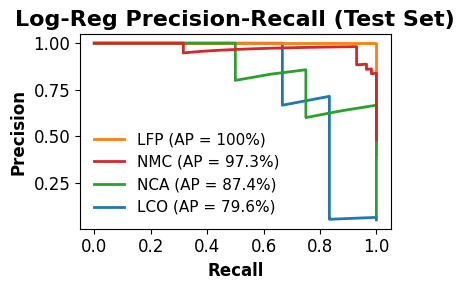


Average Precision Scores (Test Set):
  LCO: 79.6%
  LFP: 100%
  NCA: 87.4%
  NMC: 97.3%


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Use the same test set and model as the confusion matrix cell
y_proba = model.predict_proba(X_test_scaled)
y_bin = label_binarize(y_test_encoded, classes=range(len(labels)))

# Plot Precision-Recall curves with transparent background
fig, ax = plt.subplots(figsize=(4, 3))
fig.patch.set_alpha(0)
ax.set_facecolor('none')
plt.rcParams['savefig.facecolor'] = 'none'

curve_info = []   # store handles + labels + AP for sorting

for i, class_name in enumerate(labels):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
    avg_precision = average_precision_score(y_bin[:, i], y_proba[:, i])

    # Format: if 100% → no decimals, else → 1 decimal
    ap_percent = avg_precision * 100
    ap_str = f"{ap_percent:.0f}%" if np.round(ap_percent, 3) == 100 else f"{ap_percent:.1f}%"

    # Plot and capture handle
    line, = ax.plot(recall, precision, linewidth=2)
    label = f"{class_name} (AP = {ap_str})"

    # Save for sorting
    curve_info.append((avg_precision, line, label))

# ---- SORT LEGEND ENTRIES BY AP DESCENDING ----
curve_info.sort(key=lambda x: x[0], reverse=True)
sorted_handles = [x[1] for x in curve_info]
sorted_labels  = [x[2] for x in curve_info]

# Apply sorted legend
leg = ax.legend(sorted_handles, sorted_labels, fontsize=11, loc='best', framealpha=0)
if leg:
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_edgecolor('none')

# Axis labels
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')

# Title
if for_report:
    ax.set_title('Precision-Recall Curves', fontsize=16, fontweight='bold')
else:
    ax.set_title('Precision-Recall Curves - Logistic Regression', fontsize=14, fontweight='bold')

ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

# ---- PRINT SCORES (same formatting rule) ----
print("\nAverage Precision Scores (Test Set):")
for i, class_name in enumerate(labels):
    ap_score = average_precision_score(y_bin[:, i], y_proba[:, i])
    ap_percent = ap_score * 100
    ap_str = f"{ap_percent:.0f}%" if np.round(ap_percent, 3) == 100 else f"{ap_percent:.1f}%"
    print(f"  {class_name}: {ap_str}")


C:\Users\MJone\AppData\Local\Temp\ipykernel_63720\118569066.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = plot_df.groupby('mv_bin').mean(numeric_only=True).reset_index()


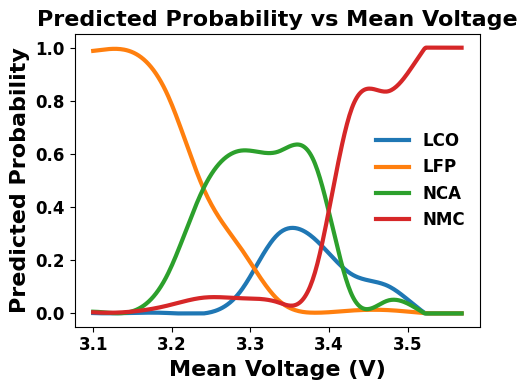

In [41]:
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline, BSpline

# Ensure required columns exist
mean_volt_cols = [c for c in X_test.columns if c.endswith('voltage_v_mean')]
if len(mean_volt_cols) == 0:
    raise ValueError("No '*voltage_v_mean' columns found in X_test. Expected e.g. 'discharge_voltage_v_mean'.")

# Prefer discharge mean voltage if present, else use the first available
mv_col = next((c for c in mean_volt_cols if 'discharge_' in c), mean_volt_cols[0])

# Predicted probabilities for test set
y_proba = model.predict_proba(X_test_scaled)

# Build plotting DataFrame
plot_df = pd.DataFrame({'mean_voltage': X_test[mv_col].values})
for i, cls in enumerate(labels):
    plot_df[f'proba_{cls}'] = y_proba[:, i]

# Bin mean voltage for smoother base points
bins = np.linspace(plot_df['mean_voltage'].min(), plot_df['mean_voltage'].max(), 12)
plot_df['mv_bin'] = pd.cut(plot_df['mean_voltage'], bins=bins, include_lowest=True)
agg = plot_df.groupby('mv_bin').mean(numeric_only=True).reset_index()
agg['mv_mid'] = agg['mv_bin'].apply(lambda x: (x.left + x.right) / 2 if pd.notna(x) else np.nan)

# Plot with transparent background
fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_alpha(0)
ax.set_facecolor('none')
plt.rcParams['savefig.facecolor'] = 'none'


# Smooth and plot each class
for cls in labels:
    x = agg['mv_mid'].to_numpy()
    y = agg[f'proba_{cls}'].to_numpy()

    # clean/sort/unique for spline
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    order = np.argsort(x)
    x, y = x[order], y[order]
    x_u, idx = np.unique(x, return_index=True)
    y_u = y[idx]

    # build spline if enough points, else fall back to raw
    if len(x_u) >= 4:
        xnew = np.linspace(x_u.min(), x_u.max(), 300)
        spl = make_interp_spline(x_u, y_u, k=3)  # cubic spline
        power_smooth = np.clip(spl(xnew), 0, 1)  # keep within [0,1]
        ax.plot(xnew, power_smooth, linewidth=3, label=cls)
    else:
        ax.plot(x_u, y_u, linewidth=3, label=cls)

ax.set_xlabel('Mean Voltage (V)', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted Probability', fontsize=16, fontweight='bold')
ax.set_title('Predicted Probability vs Mean Voltage', fontsize=16, fontweight='bold')



leg = ax.legend(fontsize=12, loc='best', framealpha=0)
if leg:
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_edgecolor('none')
    #set bold for legend text
    for text in leg.get_texts():
        text.set_fontweight('bold')

ax.tick_params(axis='both', labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.show()